## Task 2 [2p*]

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file](https://drive.google.com/file/d/1H0ChgZjcbW7x3Gy_9RK0CoduP5M8WscP/view?usp=drive_link) containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

In [8]:
input_wiki_file = "input/simple.wiki.links.txt"


In [9]:
def tokenize(title):
    for c in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~':
        title = title.replace(c, ' ' + c + ' ')
    return title.lower().split()


___

In [10]:
from gensim.models.word2vec import LineSentence
from gensim.test.utils import datapath

# with open(input_wiki_file, 'r', encoding='utf-8') as f:
#     content = f.read()
# content = tokenize(content)

# sentences = LineSentence(content)

sentences = LineSentence(input_wiki_file)


In [11]:
from gensim.models import Word2Vec

model_basic = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=6)
model_basic.save("output/model_basic_links_only.w2v")


___

In [12]:
with open(input_wiki_file, "r", encoding="utf-8") as f:
    original_pairs = [line.strip().lower().split() for line in f]

original_pairs = [pair for pair in original_pairs if len(pair) == 2]


In [13]:
from collections import Counter
import itertools

title_tokens = [tokenize(t) for pair in original_pairs for t in pair]
word_counter = Counter(itertools.chain.from_iterable(title_tokens))


In [14]:
def get_valuable_bigrams(token_lists, min_count=5, delta=0.5, top_n=1000):
    """
    Finds valuable bigrams in a corpus of tokenized sentences
    Returns a set of bigrams to merge (as tuples)
    """
    from collections import Counter
    import itertools

    # count unigrams and bigrams
    unigram_counts = Counter(itertools.chain.from_iterable(token_lists))
    bigram_counts = Counter(itertools.chain.from_iterable(
        zip(tokens, tokens[1:]) for tokens in token_lists if len(tokens) > 1
    ))

    # compute bigram scores
    scores = {}
    for (w1, w2), bigram_count in bigram_counts.items():
        if unigram_counts[w1] > 0 and unigram_counts[w2] > 0 and bigram_count >= min_count:
            score = (bigram_count - delta) / (unigram_counts[w1] * unigram_counts[w2])
            scores[(w1, w2)] = score

    # select top_n bigrams by score
    valuable_bigrams = set(sorted(scores, key=scores.get, reverse=True)[:top_n])
    return valuable_bigrams

def merge_bigrams(tokens, bigrams_to_merge):
    """
    Replaces valuable bigrams in a token list with a single token joined by '_'
    """
    i = 0
    merged = []
    while i < len(tokens):
        if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) in bigrams_to_merge:
            merged.append(f"{tokens[i]}_{tokens[i+1]}")
            i += 2
        else:
            merged.append(tokens[i])
            i += 1
    return merged

def get_bigrams(tokens):
    """
    Returns a list of bigrams (as tuples) from a list of tokens
    """
    if len(tokens) < 2:
        return []
    return list(zip(tokens, tokens[1:]))


In [15]:
# valuable_bigrams = get_valuable_bigrams(title_tokens, min_count=5, delta=0.5, top_n=1000)
# merged_title_tokens = [merge_bigrams(tokens, valuable_bigrams) for tokens in title_tokens]

bigram_counter = Counter(itertools.chain.from_iterable(
    [get_bigrams(t) for t in title_tokens]
))

In [16]:
RARE_THRESHOLD = 10
rare_words = set(w for w, c in word_counter.items() if c <= RARE_THRESHOLD)
rare_bigrams = set(b for b, c in bigram_counter.items() if c <= RARE_THRESHOLD)


In [17]:
from itertools import combinations

title_to_tokens = {t: tokenize(t) for t in set(
    itertools.chain.from_iterable(original_pairs)
)}
title_list = list(title_to_tokens.keys())

# --- index of titles by rare features ---
# for rare word get titles containing it
word_index = {}
for title, tokens in title_to_tokens.items():
    # get rare tokens from title
    features = set(tokens).intersection(rare_words)
    for f in features:
        word_index.setdefault(f, set()).add(title)

# for rare bigram get titles containing it
bigram_index = {}
for title, tokens in title_to_tokens.items():
    features = set(get_bigrams(tokens)).intersection(rare_bigrams)
    for b in features:
        bigram_index.setdefault(b, set()).add(title)

# create set of related pairs
related_pairs = set()
for index in (word_index, bigram_index):
    for titles in index.values():
        for a, b in combinations(titles, 2):
            related_pairs.add((a, b))


In [18]:
# combine/mix original pairs/sentences with related pairs
combined_pairs = original_pairs + list(related_pairs)
combined_sentences = [tokenize(a) + tokenize(b) for a, b in combined_pairs]


In [19]:
model_mixed = Word2Vec(sentences=combined_sentences, vector_size=100, window=5, min_count=1, workers=6)
model_mixed.save("output/model_mixed_links_plus_related.w2v")


___

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize(model, title_tokens, num=100):
    words = list(title_tokens.keys())[:num]
    words_with_vectors = [' '.join(tokenize(w)) for w in words if ' '.join(tokenize(w)) in model.wv]
    orig_words = [w for w in words if ' '.join(tokenize(w)) in model.wv]
    vectors = [model.wv[w] for w in words_with_vectors]
    reduced = PCA(n_components=2).fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    for i, word in enumerate(orig_words):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.text(reduced[i, 0], reduced[i, 1], word, fontsize=9)
    plt.title("PCA of title vectors")
    plt.grid(True)
    plt.show()


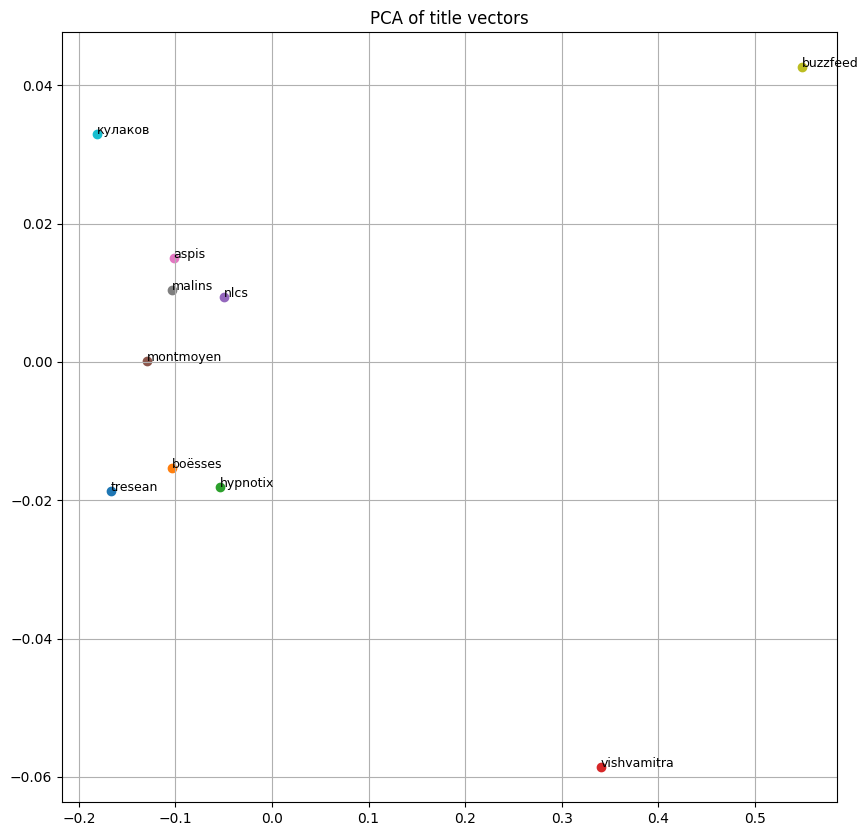

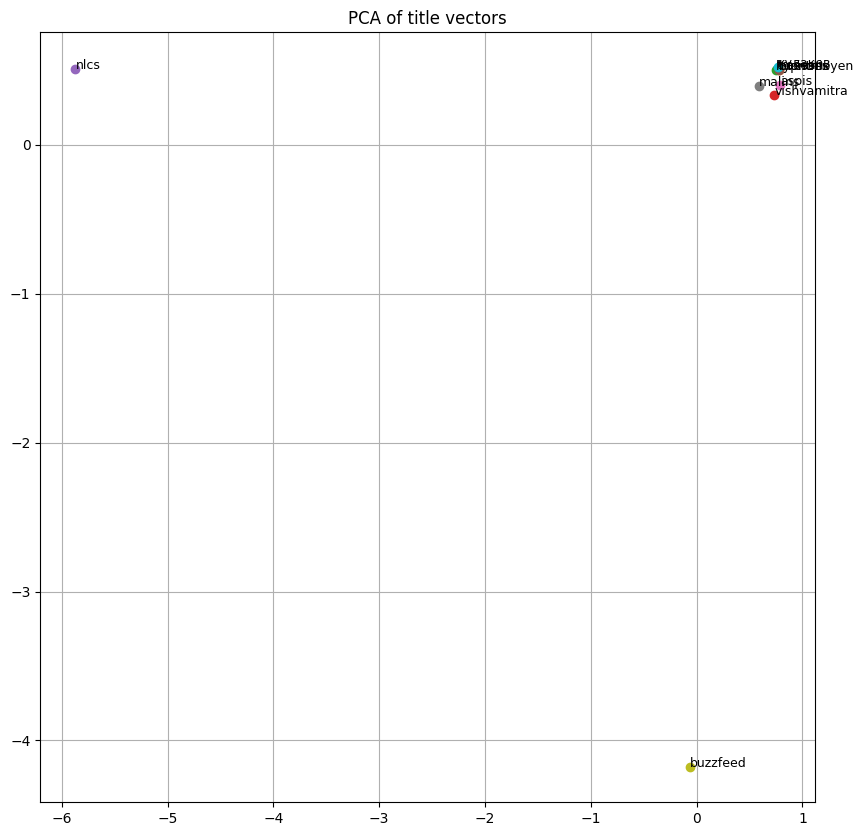

In [21]:
visualize(model_basic, title_to_tokens)
visualize(model_mixed, title_to_tokens)

In [22]:
def display_similar_words(word, model, topn=5):
    if word in model.wv:
        print(f"\n{word}:")
        for sim_word, score in model.wv.most_similar(word, topn=topn):
            print(f"  {sim_word} ({score:.3f})")
    else:
        print(f"\n{word}: not in vocabulary")

example_words = ["science", "history", "computer", "music"]

print("Similar words from model_basic:")
for word in example_words:
    display_similar_words(word, model_basic)

print("\nSimilar words from model_mixed:")
for word in example_words:
    display_similar_words(word, model_mixed)


Similar words from model_basic:

science:
  mars (0.975)
  charles_darwin (0.974)
  astronomy (0.973)
  orbit (0.972)
  biology (0.970)

history:
  culture (0.987)
  war (0.984)
  christian (0.983)
  americas (0.982)
  caribbean (0.981)

computer:
  genetics (0.942)
  female (0.935)
  gas (0.929)
  dog (0.928)
  galaxy (0.924)

music:
  rock_and_roll (0.961)
  book (0.957)
  electric_guitar (0.956)
  song (0.955)
  internet (0.953)

Similar words from model_mixed:

science:
  technology (0.588)
  scientific (0.540)
  society (0.535)
  astronautical (0.527)
  children (0.523)

history:
  politics (0.629)
  geography (0.627)
  demographics (0.620)
  economy (0.606)
  subfields (0.575)

computer:
  computing (0.691)
  audio (0.586)
  application (0.583)
  laptop (0.569)
  interface (0.565)

music:
  musical (0.654)
  grammy (0.597)
  dance (0.570)
  albums (0.564)
  indie (0.554)
